In [1]:
import pandas as pd
import numpy as np
import random as rd # generating random numbers
import datetime # manipulating date formats
from scipy import stats
from tqdm import tqdm_notebook
from itertools import product 

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

# settings
import warnings
import platform, sys
warnings.filterwarnings("ignore")

print('Machine: {} {}'.format(platform.uname().system, platform.uname().machine))
print("Python version: {}".format(sys.version))
print("Pandas version: {}".format(pd.__version__))

pd.set_option('display.max_columns', 500)
pd.set_option("display.max_rows", 60)
pd.set_option('display.width', 1000)

Machine: Windows AMD64
Python version: 3.6.5 |Anaconda, Inc.| (default, Mar 29 2018, 13:32:41) [MSC v.1900 64 bit (AMD64)]
Pandas version: 0.23.0


In [2]:
sales=pd.read_csv("D:\\all\\sales_train_v2.csv")
shops=pd.read_csv("D:\\all\\shops.csv")
item_cat=pd.read_csv("D:\\all\\item_categories.csv")
item=pd.read_csv("D:\\all\\items.csv")
sub=pd.read_csv("D:\\all\\sample_submission.csv")
test=pd.read_csv("D:\\all\\test.csv")

In [3]:
sales.item_price[sales.item_price<=0]

484683   -1.0
Name: item_price, dtype: float64

In [4]:
sales[(sales.item_id==2973) & (sales.shop_id==32) ]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
67427,29.01.2013,0,32,2973,2499.0,1.0
67428,25.01.2013,0,32,2973,2499.0,1.0
67429,22.01.2013,0,32,2973,2499.0,1.0
67430,21.01.2013,0,32,2973,2499.0,1.0
67431,18.01.2013,0,32,2973,2499.0,1.0
67432,17.01.2013,0,32,2973,2499.0,1.0
67433,15.01.2013,0,32,2973,2499.0,3.0
187844,05.02.2013,1,32,2973,2499.0,1.0
187845,14.02.2013,1,32,2973,2499.0,1.0
484682,23.05.2013,4,32,2973,1249.0,1.0


In [5]:
# correct negative price with the most frequent
sales.at[484683,"item_price"]=2499.0

In [6]:
#correct sales in 10th shop in 25 period - copy from 11th
sales.pivot_table(index="date_block_num", columns="shop_id", values="item_cnt_day", aggfunc="sum" )

shop_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59
date_block_num,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,5578.0,2947.0,1146.0,767.0,2114.0,NaN,3686.0,2495.0,1463.0,NaN,935.0,NaN,842.0,1178.0,1777.0,2724.0,2978.0,NaN,2856.0,3038.0,NaN,1495.0,1924.0,1948.0,1768.0,8215.0,2331.0,5548.0,7057.0,2820.0,2978.0,10173.0,1238.0,NaN,NaN,2127.0,NaN,2399.0,1704.0,NaN,NaN,1998.0,3991.0,1759.0,1708.0,1634.0,3363.0,2115.0,NaN,NaN,3406.0,2748.0,1812.0,2055.0,9386.0,NaN,3238.0,NaN,NaN,2017.0
1,6127.0,3364.0,488.0,798.0,2025.0,877.0,4007.0,2513.0,1156.0,NaN,1026.0,NaN,1209.0,1036.0,1795.0,2746.0,2614.0,NaN,3341.0,2834.0,NaN,1854.0,2447.0,1941.0,1782.0,7934.0,2597.0,4546.0,5438.0,2834.0,2717.0,11160.0,1494.0,NaN,NaN,2205.0,NaN,2216.0,1670.0,NaN,NaN,1856.0,3965.0,2033.0,1823.0,1530.0,2660.0,1824.0,NaN,NaN,3054.0,2284.0,1737.0,1906.0,8075.0,NaN,2655.0,NaN,NaN,1897.0
2,NaN,NaN,753.0,959.0,2060.0,1355.0,4519.0,2460.0,977.0,NaN,1017.0,NaN,1419.0,1245.0,1893.0,2835.0,3088.0,NaN,3551.0,3020.0,NaN,2233.0,2588.0,2118.0,2014.0,9732.0,3036.0,5454.0,6918.0,3151.0,3026.0,12670.0,1890.0,NaN,NaN,2568.0,NaN,2629.0,2009.0,NaN,NaN,1816.0,4953.0,2504.0,2131.0,1883.0,3103.0,1977.0,NaN,NaN,3610.0,2605.0,2034.0,2365.0,9488.0,NaN,3099.0,6586.0,3773.0,2028.0
3,NaN,NaN,583.0,647.0,285.0,1008.0,3168.0,1540.0,-1.0,NaN,756.0,NaN,1364.0,1018.0,1247.0,2168.0,2118.0,NaN,2421.0,2291.0,NaN,1846.0,2297.0,1698.0,787.0,7867.0,2381.0,3946.0,4910.0,2252.0,2379.0,9621.0,1364.0,NaN,NaN,1845.0,NaN,1946.0,1375.0,NaN,NaN,1387.0,3978.0,1880.0,1628.0,1253.0,2160.0,1540.0,NaN,NaN,2740.0,1945.0,1446.0,1515.0,6726.0,NaN,2153.0,5493.0,2831.0,1388.0
4,NaN,NaN,553.0,710.0,1211.0,1110.0,3022.0,1647.0,NaN,NaN,683.0,NaN,917.0,1104.0,1489.0,1931.0,2261.0,NaN,2944.0,2089.0,NaN,1646.0,1755.0,NaN,1967.0,6860.0,2148.0,3518.0,5703.0,2345.0,2304.0,9423.0,1209.0,NaN,NaN,2048.0,NaN,2019.0,1337.0,NaN,NaN,1597.0,3594.0,1624.0,1379.0,1333.0,2522.0,1724.0,NaN,NaN,2839.0,2243.0,1482.0,1767.0,7006.0,852.0,2140.0,5233.0,2308.0,1374.0
5,NaN,NaN,832.0,784.0,1464.0,1393.0,3847.0,2085.0,NaN,NaN,764.0,NaN,1710.0,1358.0,1863.0,2419.0,3075.0,906.0,3144.0,2638.0,NaN,1912.0,2243.0,NaN,2599.0,8478.0,2661.0,275.0,7056.0,2803.0,2794.0,10072.0,1493.0,NaN,NaN,2280.0,NaN,1829.0,1539.0,NaN,NaN,2185.0,4349.0,2060.0,1666.0,1785.0,2865.0,1654.0,NaN,NaN,3761.0,2200.0,1815.0,2125.0,8101.0,728.0,3105.0,5987.0,2972.0,1707.0
6,NaN,NaN,807.0,721.0,1378.0,1265.0,3360.0,2031.0,NaN,NaN,800.0,NaN,723.0,1094.0,1709.0,2599.0,2898.0,1044.0,2676.0,2459.0,NaN,1860.0,1903.0,NaN,2377.0,7361.0,2163.0,4148.0,6739.0,2205.0,2438.0,9500.0,93.0,NaN,NaN,2041.0,NaN,1293.0,1453.0,NaN,NaN,1997.0,3801.0,1632.0,1487.0,1507.0,2966.0,1329.0,NaN,NaN,3235.0,2273.0,1616.0,1975.0,7225.0,795.0,3294.0,5827.0,3122.0,1747.0
7,NaN,NaN,875.0,890.0,1713.0,1510.0,3702.0,2397.0,NaN,NaN,755.0,NaN,1599.0,944.0,2216.0,2536.0,2457.0,1306.0,1778.0,2675.0,NaN,2061.0,2017.0,NaN,2304.0,7784.0,2452.0,4925.0,7521.0,2073.0,2799.0,9882.0,NaN,NaN,NaN,2391.0,NaN,1472.0,1895.0,NaN,NaN,2149.0,4035.0,1849.0,1610.0,1649.0,3315.0,1610.0,NaN,NaN,3718.0,2142.0,1772.0,2367.0,7792.0,719.0,3311.0,5413.0,2863.0,2048.0
8,NaN,NaN,945.0,1026.0,1536.0,1298.0,4208.0,2599.0,NaN,NaN,1027.0,NaN,2032.0,1153.0,796.0,2790.0,1924.0,1459.0,2774.0,2801.0,NaN,2486.0,2518.0,NaN,3072.0,9251.0,3206.0,4981.0,6753.0,2832.0,3023.0,11204.0,NaN,NaN,NaN,2473.0,NaN,1666.0,1666.0,NaN,NaN,2146.0,5093.0,2768.0,1849.0,1725.0,2963.0,1742.0,NaN,NaN,3655.0,1903.0,2125.0,2440.0,7827.0,812.0,2829.0,5213.0,2735.0,2008.0


In [7]:
t2=sales[(sales["shop_id"]==11) & (sales["date_block_num"]==25)]
for i,j in t2.iterrows():
    t2.at[i, "shop_id"]=10


In [8]:
sales=pd.concat([sales,t2], ignore_index=True)
#sales[(sales["shop_id"]==10) & (sales["date_block_num"]==25)]

In [9]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [9]:
shops["city"]=shops["shop_name"].map(lambda x: str(x).split()[0])
shops.head()

,shop_name,shop_id,city
0,"!Якутск Орджоникидзе, 56 фран",0,!Якутск
1,"!Якутск ТЦ ""Центральный"" фран",1,!Якутск
2,"Адыгея ТЦ ""Мега""",2,Адыгея
3,"Балашиха ТРК ""Октябрь-Киномир""",3,Балашиха
4,"Волжский ТЦ ""Волга Молл""",4,Волжский


In [56]:
shops.city.value_counts()

Москва              13
Тюмень               3
Воронеж              3
РостовНаДону         3
Уфа                  2
СПб                  2
Красноярск           2
Жуковский            2
Казань               2
Н.Новгород           2
Якутск               2
Новосибирск          2
Самара               2
!Якутск              2
Волжский             1
Томск                1
Чехов                1
Цифровой             1
Мытищи               1
Интернет-магазин     1
Омск                 1
Балашиха             1
Ярославль            1
Выездная             1
Калуга               1
Вологда              1
Сургут               1
Химки                1
Коломна              1
Сергиев              1
Курск                1
Адыгея               1
Name: city, dtype: int64

In [10]:
needed_shops=test["shop_id"].unique()
all_shops=range(0,59)
drop_shops=set(all_shops)-set(needed_shops)

In [11]:
shops1=shops.copy()

In [12]:
shops1.drop(drop_shops, axis=0, inplace=True)
shops1.city.value_counts()

Москва              7
Новосибирск         2
Самара              2
РостовНаДону        2
Воронеж             2
Якутск              2
Уфа                 2
Тюмень              2
Н.Новгород          2
Томск               1
Казань              1
Ярославль           1
Омск                1
Курск               1
Цифровой            1
СПб                 1
Калуга              1
Адыгея              1
Сергиев             1
Вологда             1
Волжский            1
Чехов               1
Жуковский           1
Балашиха            1
Сургут              1
Коломна             1
Интернет-магазин    1
Красноярск          1
Name: city, dtype: int64

In [74]:
shops1.head(10)

,shop_name,shop_id,city
2,"Адыгея ТЦ ""Мега""",2,Адыгея
3,"Балашиха ТРК ""Октябрь-Киномир""",3,Балашиха
4,"Волжский ТЦ ""Волга Молл""",4,Волжский
5,"Вологда ТРЦ ""Мармелад""",5,Вологда
6,"Воронеж (Плехановская, 13)",6,Воронеж
7,"Воронеж ТРЦ ""Максимир""",7,Воронеж
10,Жуковский ул. Чкалова 39м?,10,Жуковский
12,Интернет-магазин ЧС,12,Интернет-магазин
14,"Казань ТЦ ""ПаркХаус"" II",14,Казань
15,"Калуга ТРЦ ""XXI век""",15,Калуга


In [155]:
#shops3=pd.merge(shops, shops1,  how="left", on=["shop_id"] )
#shops3.sort_values(by="shop_name_y")

In [14]:
sales["date"]=sales["date"].apply(lambda x: datetime.datetime.strptime(x, '%d.%m.%Y'))

In [13]:
#add city column to sales data
sales=pd.merge(sales, shops[["shop_id","city"]], how="left", on="shop_id")

In [14]:
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,city
0,02.01.2013,0,59,22154,999.00,1.0,Ярославль
1,03.01.2013,0,25,2552,899.00,1.0,Москва
2,05.01.2013,0,25,2552,899.00,-1.0,Москва
3,06.01.2013,0,25,2554,1709.05,1.0,Москва
4,15.01.2013,0,25,2555,1099.00,1.0,Москва


In [105]:
# check Moscow performance by shop
#t1=sales[sales.city=="Москва"]
#t1
#t2=t1.groupby(["shop_id", "date_block_num"])["item_cnt_day"].agg(["sum"])
t2.unstack()

sum                                                                                                                                                                                                                                                                                 
date_block_num       0        1        2       3       4        5       6       7        8        9        10       11       12      13      14      15      16      17      18      19      20      21      22       23      24      25      26      27      28      29      30      31      32      33
shop_id                                                                                                                                                                                                                                                                                                 
20                  NaN      NaN      NaN     NaN     NaN      NaN     NaN     NaN      NaN      NaN      NaN      NaN      NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN  3261.0     NaN      NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN  2611.0
21               1495.0   1854.0   2233.0  1846.0  1646.0   1912.0  1860.0  2061.0   2486.0   2015.0   2174.0   3623.0   1844.0  1822.0  2088.0  2144.0  1909.0  1849.0  1603.0  1749.0  1897.0  2031.0  2222.0   3959.0  1923.0  1839.0  1687.0  2053.0  1717.0  1844.0  1741.0  1622.0  1900.0  1912.0
22               1924.0   2447.0   2588.0  2297.0  1755.0   2243.0  1903.0  2017.0   2518.0   2364.0   2224.0   2618.0   1522.0  2007.0  1982.0  1826.0  1496.0  1246.0  1243.0  1260.0  1754.0  1633.0  1906.0   2426.0  1255.0  1301.0  1547.0  1664.0  1357.0  1102.0   993.0  1044.0  1432.0  1336.0
23               1948.0   1941.0   2118.0  1698.0     NaN      NaN     NaN     NaN      NaN      NaN      NaN      NaN      NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN      NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN
24               1768.0   1782.0   2014.0   787.0  1967.0   2599.0  2377.0  2304.0   3072.0   2654.0   2643.0   3971.0   2463.0  2135.0  2541.0  1742.0  1667.0  1708.0  1553.0  1719.0  1488.0  1498.0  2091.0   2765.0  1750.0  1309.0  1284.0  1297.0  1137.0   882.0  1014.0  1186.0  1492.0  1227.0
25               8215.0   7934.0   9732.0  7867.0  6860.0   8478.0  7361.0  7784.0   9251.0   8356.0   8632.0  12102.0   6835.0  6686.0  6826.0  5939.0  5746.0  6405.0  5620.0  6205.0  6158.0  6375.0  7681.0  12257.0  6611.0  5566.0  6007.0  6135.0  5712.0  5093.0  4676.0  4675.0  5893.0  6247.0
26               2331.0   2597.0   3036.0  2381.0  2148.0   2661.0  2163.0  2452.0   3206.0   2441.0   2409.0   3391.0   1929.0  2307.0  2063.0  1587.0  1764.0  1598.0  1459.0  1527.0  1910.0  1900.0  2061.0   3033.0  1715.0  1339.0  1486.0  1527.0  1358.0   953.0  1007.0  1189.0  1553.0  1409.0
27               5548.0   4546.0   5454.0  3946.0  3518.0    275.0  4148.0  4925.0   4981.0   4297.0   4805.0   7983.0   5451.0  4208.0  4475.0  4204.0  4505.0  4282.0  3756.0  4760.0  4026.0  3722.0  4675.0   7896.0  5660.0  3839.0  3634.0  3518.0  3786.0  3357.0  2478.0     NaN    -1.0     NaN
28               7057.0   5438.0   6918.0  4910.0  5703.0   7056.0  6739.0  7521.0   6753.0   5609.0   6454.0   8499.0   6949.0  5498.0  5901.0  4581.0  4902.0  5701.0  4536.0  5802.0  4403.0  4695.0  5492.0   7439.0  6879.0  4234.0  4139.0  3686.0  3784.0  3921.0  3612.0  3749.0  2979.0  3018.0
29               2820.0   2834.0   3151.0  2252.0  2345.0   2803.0  2205.0  2073.0   2832.0   2151.0   2421.0   3057.0   1981.0  1920.0  1945.0  1838.0  1799.0  1430.0  1433.0  1559.0  1723.0  1641.0  1926.0   2402.0  1564.0  1273.0  1239.0  1216.0   880.0     NaN     NaN     NaN     NaN     NaN
30               2978.0   2717.0   3026.0  2379.0  2304.0   2794.0  2438.0  2799.0   3023.0   2888.0   2599.0   3566.0   2383.0  2260.0  2361.0  1995.0  1960.0

In [117]:
moscow_shops=[j[1] for i, j in shops.iterrows() if j[2]=="Москва"]
moscow_shops

[20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]

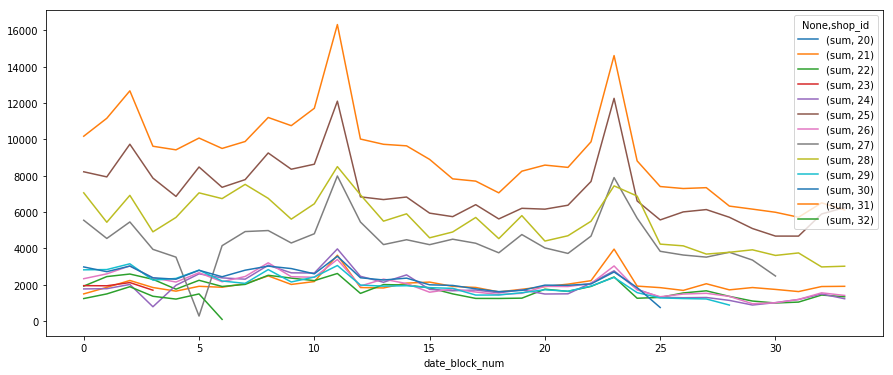

In [129]:
#plt.figure()
t2.unstack(level=0).plot(figsize=(15,6))

In [15]:
# remove cities which are not asked to predeict
cities_remove=set(shops.city)-set(shops1.city)
cities_remove
indices_remove=[i for i, j in sales.iterrows() if j[6] in cities_remove]
sales1 = sales.drop(indices_remove, axis=0)

In [16]:
cities_remove

{'!Якутск', 'Выездная', 'Мытищи', 'Химки'}

In [19]:
sales1.groupby("city")["shop_id"].value_counts()

city              shop_id
Адыгея            2           25991
Балашиха          3           25532
Волжский          4           38242
Вологда           5           38179
Воронеж           6           82663
                  7           58076
                  8            3412
Жуковский         10          21896
                  11            499
Интернет-магазин  12          34694
Казань            14          36979
                  13          17824
Калуга            15          59511
Коломна           16          52734
Красноярск        18          53227
                  17          22950
Курск             19          63911
Москва            31         235636
                  25         186104
                  28         142234
                  27         105366
                  21          58133
                  26          53910
                  24          53032
                  30          50860
                  29          49225
                  22          45434
  

In [17]:
needed_shops=test["shop_id"].unique()
all_shops=range(0,59)
drop_shops=set(all_shops)-set(needed_shops)

In [18]:
sales1.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,city
0,02.01.2013,0,59,22154,999.00,1.0,Ярославль
1,03.01.2013,0,25,2552,899.00,1.0,Москва
2,05.01.2013,0,25,2552,899.00,-1.0,Москва
3,06.01.2013,0,25,2554,1709.05,1.0,Москва
4,15.01.2013,0,25,2555,1099.00,1.0,Москва


In [19]:
indices_remove=[i for i, j in sales1.iterrows() if j[2] in drop_shops]
sales2 = sales1.drop(indices_remove, axis=0)

In [20]:
from fbprophet import Prophet

In [21]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


### by item

In [22]:
sales_item=sales2.groupby(["shop_id","item_id","date_block_num"])["item_cnt_day"].sum()
sales_item=sales_item.unstack().fillna(0)
sales_item=sales_item.T
dates=pd.date_range(start = '2013-01-01',end='2015-10-01', freq = 'MS')
sales_item.index=dates
sales_item=sales_item.reset_index()
sales_item.head()

shop_id      index    2                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            \
item_id              27   30   31   32   33   53   59   66   67   70   76   77   97   99  257  258  317  438  464  471  472  481  482  484  485  486  491  494  496  534  556  565  580  638  642  651  657  677  686  687  700  784  785  786  787  790  791  792  794  802  804  806  812  829  832  835  839  934  935  944  948  949  950  951  961  963  968  971  972  975  981  982  983  984  987  988  989  991  992  995  998  999 1000 1001 1007 1010 1013 1015 1016 1020 1021 1023 1025 1026 1031 1032 1035 1059 1067 1075 1076 1077 1090 1099 1108 1109 1110 1112 1121 1167 1197 1204 1224 1233 1235 1247 1249 1250 1285 1286 1288 1306 1307 1315 1362 1364 1371 1375 1377 1382 1384 1387 1388 1389 1390 1391 1397 1398 1402 1403 1406 1407 1408 1409 1412 1413 1414 1415 1416 1417 1418 1419 1420 1421 1430 1438 1439 1440 1441 1448 1449 1451 1453 1454 1459 1460 1461 1462 1463 1464 1465 1466 1467 1468 1469 1470 1471 1472 1473 1475 1476 1477 1479 1480 1481 1483 1484 1485 1486 1495 1496 1497 1498 1499 1501   
0       2013-01-01  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  2.0  0.0  1.0  1.0  2.0  0.0  0.0  1.0  0.0  0.0  2.0  1.0  0.0  0.0  0.0  2.0  2.0  3.0  3.0  0.0  0.0  4.0  0.0  1.0  0.0  0.0  0.0  2.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0  2.0  1.0  1.0  1.0  3.0  1.0  3.0  0.0  0.0  0.0  2.0  2.0  0.0  1.0  0.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  1.0  0.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  3.0  0.0  3.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  4.0  2.0  3.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1       2013-02-01  0.0  0.0  4.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  4.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  2.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  2.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  4.0  3.0  2.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2       2013

In [ ]:
%%time
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

    
# Bottoms up
# Calculating the base forecasts using prophet
# From HTSprophet pachage -- https://github.com/CollinRooney12/htsprophet/blob/master/htsprophet/hts.py
forecastsDict = {}
errors={}
for node in tqdm_notebook(range(sales_item.shape[1]-1)):
    nodeToForecast = pd.concat([sales_item.iloc[:,0], sales_item.iloc[:, node+1]], axis = 1)
    nodeToForecast = nodeToForecast.rename(columns = {"index" : 'ds'})
    nodeToForecast["y"] = nodeToForecast[nodeToForecast.columns[1]]
    nodeToForecast.drop(nodeToForecast.columns[1], axis=1, inplace=True)
    growth = 'linear'
    m = Prophet(growth, yearly_seasonality=True)
    
     # we need try-except because on some combinations model fails to converge
    try:
        m.fit(nodeToForecast)
        future = m.make_future_dataframe(periods = 1, freq = 'MS')
        forecast=m.predict(future)
    except:
        continue

    forecastsDict[sales_item.columns.values[node+1]] = forecast
    errors[sales_item.columns.values[node+1]]=mean_absolute_percentage_error(sales_item.iloc[:, node+1],
                                                                             forecast.iloc[:-1,-1])
    #if (node== 50):
        #print("ready")
        #break

In [33]:
forecastsDict.keys()

dict_keys([(2, 27), (2, 30), (2, 31), (2, 32), (2, 33), (2, 53), (2, 59), (2, 66), (2, 67), (2, 70), (2, 76), (2, 77), (2, 97), (2, 99), (2, 257), (2, 258), (2, 317), (2, 438), (2, 464), (2, 471), (2, 472), (2, 481), (2, 482), (2, 484), (2, 485), (2, 486), (2, 491), (2, 494), (2, 496), (2, 534), (2, 556), (2, 565), (2, 580), (2, 638)])

In [ ]:
%%time
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

    
# Bottoms up
# Calculating the base forecasts using prophet
# From HTSprophet pachage -- https://github.com/CollinRooney12/htsprophet/blob/master/htsprophet/hts.py
forecastsDict = {}
errors={}

for node in range(len(sales_item)):
    # take the date-column and the col to be forecasted
    nodeToForecast = pd.concat([sales_item.iloc[:,0], sales_item.iloc[:, node+1]], axis = 1)
#     print(nodeToForecast.head())  # just to check
# rename for prophet compatability
    nodeToForecast = nodeToForecast.rename(columns = {"index" : 'ds'})
    nodeToForecast["y"] = nodeToForecast[nodeToForecast.columns[1]]
    nodeToForecast.drop(nodeToForecast.columns[1], axis=1, inplace=True)
    growth = 'linear'
    m = Prophet(growth, yearly_seasonality=True)
    m.fit(nodeToForecast)
    future = m.make_future_dataframe(periods = 1, freq = 'MS')
    forecast=m.predict(future)
    forecastsDict[sales_item.columns.values[node+1]] = forecast
    errors[sales_item.columns.values[node+1]]=mean_absolute_percentage_error(sales_item.iloc[:, node+1],
                                                                             forecast.iloc[:-1,-1])
    if (node== 10):
        break

### by shop 

In [323]:
sales3=sales2.groupby([ "date_block_num", "shop_id" ])["item_cnt_day"].sum()
sales3=sales3.unstack(level=1)
sales3=sales3.fillna(0)
dates=pd.date_range(start = '2013-01-01',end='2015-10-01', freq = 'MS')
sales3.index=dates
sales3=sales3.reset_index()

In [338]:
sales3

shop_id,index,2,3,4,5,6,7,10,12,14,15,16,18,19,21,22,24,25,26,28,31,34,35,36,37,38,39,41,42,44,45,46,47,48,49,50,52,53,55,56,57,58,59
0,2013-01-01,1146.0,767.0,2114.0,0.0,3686.0,2495.0,935.0,842.0,1777.0,2724.0,2978.0,2856.0,3038.0,1495.0,1924.0,1768.0,8215.0,2331.0,7057.0,10173.0,0.0,2127.0,0.0,2399.0,1704.0,0.0,1998.0,3991.0,1708.0,1634.0,3363.0,2115.0,0.0,0.0,3406.0,1812.0,2055.0,0.0,3238.0,0.0,0.0,2017.0
1,2013-02-01,488.0,798.0,2025.0,877.0,4007.0,2513.0,1026.0,1209.0,1795.0,2746.0,2614.0,3341.0,2834.0,1854.0,2447.0,1782.0,7934.0,2597.0,5438.0,11160.0,0.0,2205.0,0.0,2216.0,1670.0,0.0,1856.0,3965.0,1823.0,1530.0,2660.0,1824.0,0.0,0.0,3054.0,1737.0,1906.0,0.0,2655.0,0.0,0.0,1897.0
2,2013-03-01,753.0,959.0,2060.0,1355.0,4519.0,2460.0,1017.0,1419.0,1893.0,2835.0,3088.0,3551.0,3020.0,2233.0,2588.0,2014.0,9732.0,3036.0,6918.0,12670.0,0.0,2568.0,0.0,2629.0,2009.0,0.0,1816.0,4953.0,2131.0,1883.0,3103.0,1977.0,0.0,0.0,3610.0,2034.0,2365.0,0.0,3099.0,6586.0,3773.0,2028.0
3,2013-04-01,583.0,647.0,285.0,1008.0,3168.0,1540.0,756.0,1364.0,1247.0,2168.0,2118.0,2421.0,2291.0,1846.0,2297.0,787.0,7867.0,2381.0,4910.0,9621.0,0.0,1845.0,0.0,1946.0,1375.0,0.0,1387.0,3978.0,1628.0,1253.0,2160.0,1540.0,0.0,0.0,2740.0,1446.0,1515.0,0.0,2153.0,5493.0,2831.0,1388.0
4,2013-05-01,553.0,710.0,1211.0,1110.0,3022.0,1647.0,683.0,917.0,1489.0,1931.0,2261.0,2944.0,2089.0,1646.0,1755.0,1967.0,6860.0,2148.0,5703.0,9423.0,0.0,2048.0,0.0,2019.0,1337.0,0.0,1597.0,3594.0,1379.0,1333.0,2522.0,1724.0,0.0,0.0,2839.0,1482.0,1767.0,852.0,2140.0,5233.0,2308.0,1374.0
5,2013-06-01,832.0,784.0,1464.0,1393.0,3847.0,2085.0,764.0,1710.0,1863.0,2419.0,3075.0,3144.0,2638.0,1912.0,2243.0,2599.0,8478.0,2661.0,7056.0,10072.0,0.0,2280.0,0.0,1829.0,1539.0,0.0,2185.0,4349.0,1666.0,1785.0,2865.0,1654.0,0.0,0.0,3761.0,1815.0,2125.0,728.0,3105.0,5987.0,2972.0,1707.0
6,2013-07-01,807.0,721.0,1378.0,1265.0,3360.0,2031.0,800.0,723.0,1709.0,2599.0,2898.0,2676.0,2459.0,1860.0,1903.0,2377.0,7361.0,2163.0,6739.0,9500.0,0.0,2041.0,0.0,1293.0,1453.0,0.0,1997.0,3801.0,1487.0,1507.0,2966.0,1329.0,0.0,0.0,3235.0,1616.0,1975.0,795.0,3294.0,5827.0,3122.0,1747.0
7,2013-08-01,875.0,890.0,1713.0,1510.0,3702.0,2397.0,755.0,1599.0,2216.0,2536.0,2457.0,1778.0,2675.0,2061.0,2017.0,2304.0,7784.0,2452.0,7521.0,9882.0,0.0,2391.0,0.0,1472.0,1895.0,0.0,2149.0,4035.0,1610.0,1649.0,3315.0,1610.0,0.0,0.0,3718.0,1772.0,2367.0,719.0,3311.0,5413.0,2863.0,2048.0
8,2013-09-01,945.0,1026.0,1536.0,1298.0,4208.0,2599.0,1027.0,2032.0,796.0,2790.0,1924.0,2774.0,2801.0,2486.0,2518.0,3072.0,9251.0,3206.0,6753.0,11204.0,0.0,2473.0,0.0,1666.0,1666.0,0.0,2146.0,5093.0,1849.0,1725.0,2963.0,1742.0,0.0,0.0,3655.0,2125.0,2440.0,812.0,2829.0,5213.0,2735.0,2008.0
9,2013-10-01,795.0,793.0,1482.0,1267.0,3675.0,2236.0,1013.0,1890.0,1534.0,2612.0,1800.0,2145.0,2499.0,2015.0,2364.0,2654.0,8356.0,2441.0,5609.0,10754.0,0.0,2083.0,0.0,1169.0,1519.0,0.0,2061.0,4464.0,1678.0,1593.0,2794.0,1647.0,0.0,0.0,3525.0,1965.0,2245.0,916.0,2375.0,5686.0,3022.0,1751.0


In [335]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

forecastsDict = {}
errors={}
for node in range(sales3.shape[1]-1):
    # take the date-column and the col to be forecasted
    nodeToForecast = pd.concat([sales3.iloc[:,0], sales3.iloc[:, node+1]], axis = 1)
#     print(nodeToForecast.head())  # just to check
# rename for prophet compatability
    nodeToForecast = nodeToForecast.rename(columns = {"index" : 'ds'})
    nodeToForecast["y"] = nodeToForecast[nodeToForecast.columns[1]]
    nodeToForecast.drop(nodeToForecast.columns[1], axis=1, inplace=True)
    growth = 'linear'
    m = Prophet(growth, yearly_seasonality=True)
    m.fit(nodeToForecast)
    future = m.make_future_dataframe(periods = 1, freq = 'MS')
    forecast=m.predict(future)
    #m.plot(forecast)
    forecastsDict[sales3.columns.values[node+1]] = forecast
    errors[sales3.columns.values[node+1]]=mean_absolute_percentage_error(sales3.iloc[:, node+1], forecast.iloc[:-1,-1])

In [294]:
#nCols = len(list(forecastsDict.keys()))+1
for key in forecastsDict.keys():
    f1 = np.array(forecastsDict[key].yhat)
    print("=========")
    print(f1)
    f2 = f1[:, np.newaxis]
    if key==0:
        predictions=f2.copy()
       # print(predictions.shape)
    else:
        predictions = np.concatenate((predictions, f2), axis = 1)

[ 970.30850215  713.15147431  790.87647628  690.5271857   714.47532856
  817.81670241  764.28771353  876.69010194  853.2494273   775.69891007
  998.34972026 1596.64425974 1008.58939502  769.30529613  835.64841435
  744.54413868  770.26811876  866.48037291  811.81177065  926.61741937
  898.07136256  823.94108104 1056.22391161 1651.84757336 1046.70062967
  825.42125329  880.21830255  798.44672313  825.65823373  914.58315314
  858.89293707  976.0055136   942.40433979  871.90715895 1113.70597072]
[ 810.20869844  826.13162748 1028.78938293  629.28014885  690.68602081
  759.67585682  702.14677931  870.99939724  998.49323722  791.64032033
 1002.58334155 1198.07511305  934.14812748  840.18047168  977.72258103
  739.65808696  795.1821735   823.6733612   739.06221687  890.96835097
  982.59171635  808.23088159 1031.06446515 1211.16345185  967.736078
  741.10988449  797.97815267  702.35542533  730.45072341  700.40642403
  572.90716551  696.29373791  750.13025631  611.10684433  851.51134783]
[1892.

In [336]:
errors

{2: 11.5598174267394,
 3: 3.4389675792478647,
 4: 17.169233560604873,
 5: inf,
 6: 2.750518253570224,
 7: 2.860075653107572,
 10: 5.0618472658120774,
 12: 23.330460701393033,
 14: 10.564844564924654,
 15: 4.0092603513533565,
 16: 11.759172743082724,
 18: 16.57287022185884,
 19: 2.5556296021697222,
 21: 3.974290564461833,
 22: 6.697583353090487,
 24: 16.80222915002647,
 25: 3.881495585941212,
 26: 7.837171040221485,
 28: 7.1949490829110685,
 31: 1.8088107005997933,
 34: inf,
 35: 3.0377898416844107,
 36: inf,
 37: 15.364423775452114,
 38: 5.578139552135691,
 39: inf,
 41: 13.26527315323791,
 42: 3.2660099386761523,
 44: 5.096627801199667,
 45: 4.166566969085903,
 46: 5.204860978938123,
 47: 2.547266270455515,
 48: inf,
 49: inf,
 50: 17.569364073445406,
 52: 5.252164247255632,
 53: 1.536276543789179,
 55: inf,
 56: 4.053686155191946,
 57: inf,
 58: inf,
 59: 7.292804323597822}

In [379]:
t5=pd.crosstab(sales2.shop_id, sales2.date_block_num, values=sales2["item_cnt_day"],
            margins=True, normalize=True, aggfunc='std')

In [383]:
#t5.iloc[:, -1]
sales2.groupby("shop_id")["item_cnt_day"].agg(["mean", "std"])

,mean,std
shop_id,,
2,1.178100,1.109728
3,1.110567,0.991501
4,1.149051,1.059418
5,1.120040,0.974112
6,1.215647,1.722364
7,1.154659,1.005494
10,1.146100,0.971144
12,2.117888,16.500692
14,1.254090,1.520023


In [353]:
writer = pd.ExcelWriter('output.xlsx')
test.to_excel(writer,'Sheet1')
writer.save()

In [339]:
forecastsDict[5]["yhat"][:-1]

0      956.227779
1     1077.579292
2     1326.982738
3     1023.564746
4     1091.395295
5     1225.790836
6     1211.192758
7     1444.694532
8     1255.082363
9     1179.491799
10    1417.848065
11    2174.731594
12    1010.192117
13    1072.196259
14    1302.338129
15    1028.425896
16    1102.580067
17    1221.097704
18    1219.804852
19    1449.957950
20    1252.481251
21    1171.666815
22    1415.027450
23    2157.416140
24    1064.442828
25    1065.899400
26    1277.704632
27    1033.853454
28    1113.811376
29    1216.382951
30    1228.475318
31    1454.893451
32    1249.641997
33    1163.915990
Name: yhat, dtype: float64

In [356]:
mean_absolute_percentage_error(sales3.loc[:,5], forecastsDict[5]["yhat"][:-1])

inf

In [384]:
sales3.iloc[:,5]

0     3686.0
1     4007.0
2     4519.0
3     3168.0
4     3022.0
5     3847.0
6     3360.0
7     3702.0
8     4208.0
9     3675.0
10    3938.0
11    5467.0
12    3024.0
13    3129.0
14    3105.0
15    3093.0
16    2620.0
17    2730.0
18    2543.0
19    2563.0
20    2754.0
21    2555.0
22    3150.0
23    4115.0
24    2328.0
25    2329.0
26    1981.0
27    1998.0
28    1748.0
29    1539.0
30    1484.0
31    1575.0
32    1725.0
33    1802.0
Name: 6, dtype: float64

In [393]:
from htsprophet.hts import hts, orderHier, makeWeekly
from htsprophet.htsPlot import plotNode, plotChild, plotNodeComponents


In [386]:
sales2.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,city
0,2013-01-02,0,59,22154,999.00,1.0,Ярославль
1,2013-01-03,0,25,2552,899.00,1.0,Москва
2,2013-01-05,0,25,2552,899.00,-1.0,Москва
3,2013-01-06,0,25,2554,1709.05,1.0,Москва
4,2013-01-15,0,25,2555,1099.00,1.0,Москва


In [415]:
sales5=sales2.drop(["date_block_num", "item_price"], axis=1)
counts=sales5.item_cnt_day

In [417]:
sales5.drop(["item_cnt_day"], axis=1, inplace=True)

In [419]:
sales5["item_cnt_day"]=counts

In [420]:
sales5.head()

,date,shop_id,item_id,city,item_cnt_day
0,2013-01-02,59,22154,Ярославль,1.0
1,2013-01-03,25,2552,Москва,1.0
2,2013-01-05,25,2552,Москва,-1.0
3,2013-01-06,25,2554,Москва,1.0
4,2013-01-15,25,2555,Москва,1.0


In [421]:
data=makeMonthly(sales5)

In [406]:
def makeMonthly(data):
    columnList = data.columns.tolist()
    columnCount = len(columnList)-2
    if columnCount < 1:
        sys.exit("you need at least 1 column")
    data[columnList[0]] = pd.to_datetime(data[columnList[0]])
    cl = tuple(columnList[1:-1])
    data1 = data.groupby([pd.Grouper(key = columnList[0], freq='M'), *cl], as_index = False)[columnList[-1]].sum()
    data2 = data.groupby([pd.Grouper(key = columnList[0], freq='M'), *cl])[columnList[-1]].sum()
    data1['month'] = data2.index.get_level_values(columnList[0])
    cols = data1.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    data1 = data1[cols]
    return data1


In [ ]:
data.shop_id=data.shop_id.astype('str')
data.item_id=data.item_id.astype('str')

In [ ]:
data.info()

In [ ]:
data, nodes=orderHier(data, 3, 1, 2)